In [5]:
import json

import numpy as np
import matplotlib.pyplot as plt

from experiment_utils import EXPERIMENT_PATH


plt.style.use("ggplot")

In [6]:
experiment_name = "baseline_1 (2025-04-02 17:19:29)"
experiment_dir = EXPERIMENT_PATH / experiment_name
with open(experiment_dir / "results.json", "r") as f:
    experiment_data = json.load(f)

In [31]:
search_times = np.array(experiment_data["search_times"])
filter_used = np.array(experiment_data["filter_used"])

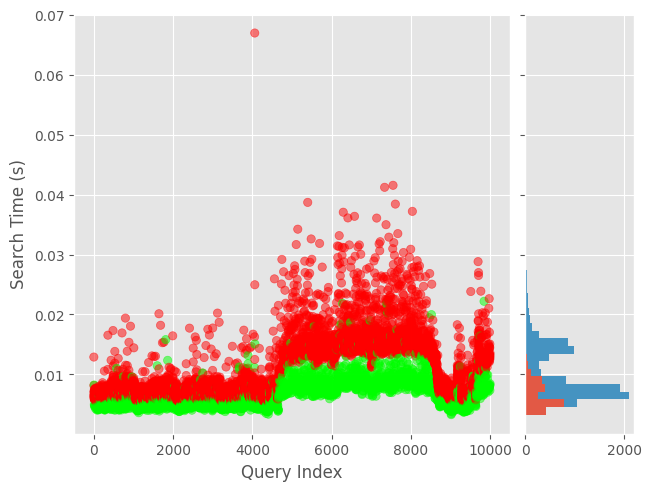

In [ ]:
fig, axes = plt.subplot_mosaic(
    [["scatter", "histogram"]],
    layout="constrained",
    width_ratios=[4, 1],
    height_ratios=[1],
)

filter_colors = np.array(["#FF0000", "#00FF00"])
filter_used_colors = filter_colors[filter_used.astype(int)]

axes["scatter"].scatter(range(len(search_times)), search_times, alpha=0.5, c=filter_used_colors)

axes["histogram"].tick_params(axis="y", labelleft=False)
axes["histogram"].hist(
    [search_times[filter_used], search_times[~filter_used]],
    bins=50,
    alpha=0.9,
    orientation="horizontal",
    stacked=True,
    label=["Filter Used", "Filter Not Used"],
    color=filter_colors,
)

axes["scatter"].set_ylabel("Search Time (s)")
axes["scatter"].set_xlabel("Query Index")

plt.show()

/tmp/ipykernel_112838/1679198579.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


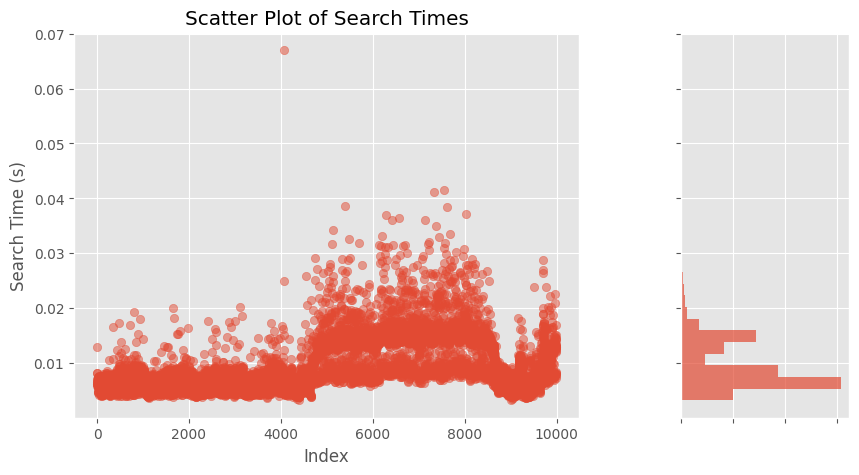

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3)

# Scatter plot
ax_scatter = fig.add_subplot(gs[0])
ax_scatter.scatter(range(len(search_times)), search_times, alpha=0.5)
ax_scatter.set_title("Scatter Plot of Search Times")
ax_scatter.set_xlabel("Index")
ax_scatter.set_ylabel("Search Time (s)")

# Histogram
ax_hist = fig.add_subplot(gs[1])
ax_hist.hist(search_times, bins=30, orientation='horizontal', alpha=0.7, density=True)
ax_hist.set_xticklabels([])
ax_hist.set_yticklabels([])

plt.show()